## Problem Statement
Build an image classification model with the tf federated framework using federated learning.

### Set up the environment

In [0]:
#@test {"skip": true}
!pip install tensorflow_federated

  Using cached https://files.pythonhosted.org/packages/85/d4/c0cd1057b331bc38b65478302114194bd8e1b9c2bbc06e300935c0e93d90/tensorflow-2.1.0-cp36-cp36m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/18/90/b77c328a1304437ab1310b463e533fa7689f4bfc41549593056d812fab8e/tensorflow_estimator-2.1.0-py2.py3-none-any.whl
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorflow 2.2.0rc1
    Uninstalling tensorflow-2.2.0rc1:
      Successfully uninstalled tensorflow-2.2.0rc1


In [0]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

tf.compat.v1.enable_v2_behavior()

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

### Prepare the input data

* Federated learning requires a federated data set, that is, a collection of data from multiple users.
* Use a federated version of MNIST that contains a version of the original NIST dataset so that the data is keyed by the original writer of the digits.

In [0]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

97402880/97398400 [==============================] - 3s 0us/step


* The data sets returned by `load_data()` are instances of
`tff.simulation.ClientData`
* ClientData is an interface that allows you to enumerate the set
of users, construct a `tf.data.Dataset` that represents the data of a
particular user, and to query the structure of individual elements. 

In [0]:
len(emnist_train.client_ids)

3383

In [0]:
emnist_train.element_type_structure

OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
             ('pixels',
              TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

In [0]:
sample_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

sample_element = next(iter(sample_dataset))

sample_element['label'].numpy()

5

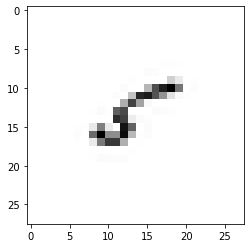

In [0]:
from matplotlib import pyplot as plt
plt.imshow(sample_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
plt.show()

### Preprocess the data
* Since the data is already a `tf.data.Dataset`,  preprocessing can be accomplished using Dataset transformations.
* Flatten the `28x28` images
into `784`-element arrays, shuffle the individual examples, organize them into batches, and renames the features
from `pixels` and `label` to `x` and `y` for use with Keras.

In [0]:
NUM_CLIENTS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER=10

def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 784]),
        y=tf.reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

### Verify the preprocess method

In [0]:
preprocessed_sample_dataset = preprocess(sample_dataset)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_sample_dataset)))

sample_batch

OrderedDict([('x', array([[1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     ...,
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)),
             ('y', array([[0],
                     [5],
                     [0],
                     [3],
                     [1],
                     [6],
                     [9],
                     [2],
                     [4],
                     [6],
                     [9],
                     [5],
                     [5],
                     [9],
                     [8],
                     [3],
                     [9],
                     [2],
                     [4],
                     [7]], dtype=int32))])

### Feed the federated data to TFF 
* Use a simple helper function that will construct a list of datasets from the given set of users as an input to a round of training or evaluation.

In [0]:
def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

### Choose clients
* Sample the set of clients once
* Reuse the same set across rounds to speed up convergence 

In [0]:
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)

print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Number of client datasets: 10
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


### Create a model with Keras


In [0]:
def create_keras_model():
  return tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=(784,)),
      tf.keras.layers.Dense(10, kernel_initializer='zeros'),
      tf.keras.layers.Softmax(),
  ])

### Wrap the model in an instance of the `tff.learning.Model` interface
* Expose methods to stamp the model's
forward pass and metadata properties
* Introduce
additional elements, such as ways to control the process of computing federated
metrics.

In [0]:
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      dummy_batch=sample_batch,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

### Train the model on federated data

* Construct a Federated Averaging algorithm by invoking the helper
function `tff.learning.build_federated_averaging_process`

In [0]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
str(iterative_process.initialize.type_signature)

'( -> <model=<trainable=<float32[784,10],float32[10]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<>,model_broadcast_state=<>>@SERVER)'

* The above type signature shows that the server state consists of a `model` (the initial model
parameters for MNIST that will be distributed to all devices), and
`optimizer_state` 

* Invoke the `initialize` computation to construct the server state.

In [0]:
state = iterative_process.initialize()

* Run a single round of training and visualize the results.

In [0]:
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

round  1, metrics=<sparse_categorical_accuracy=0.11666666716337204,loss=3.094428539276123,keras_training_time_client_sum_sec=0.0>


* Run a few more rounds.

In [0]:
NUM_ROUNDS = 11
for round_num in range(2, NUM_ROUNDS):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))

round  2, metrics=<sparse_categorical_accuracy=0.13251028954982758,loss=2.9448981285095215,keras_training_time_client_sum_sec=0.0>
round  3, metrics=<sparse_categorical_accuracy=0.15555556118488312,loss=2.8048481941223145,keras_training_time_client_sum_sec=0.0>
round  4, metrics=<sparse_categorical_accuracy=0.18024691939353943,loss=2.7044472694396973,keras_training_time_client_sum_sec=0.0>
round  5, metrics=<sparse_categorical_accuracy=0.1890946477651596,loss=2.608142137527466,keras_training_time_client_sum_sec=0.0>
round  6, metrics=<sparse_categorical_accuracy=0.20308642089366913,loss=2.468977928161621,keras_training_time_client_sum_sec=0.0>
round  7, metrics=<sparse_categorical_accuracy=0.24567900598049164,loss=2.405071973800659,keras_training_time_client_sum_sec=0.0>
round  8, metrics=<sparse_categorical_accuracy=0.26131686568260193,loss=2.274505376815796,keras_training_time_client_sum_sec=0.0>
round  9, metrics=<sparse_categorical_accuracy=0.3010288178920746,loss=2.087470054626465

Training loss is decreasing after each round of federated training, indicating
the model is converging. 

## Customize the model implementation

* Define the model variables, forward pass, and metrics.

    * Identify the TensorFlow variables you're going to work with.
    * Define a data structure
to represent the entire set icluding variables such as `weights` and
`bias` as well as variables that willbe updated during training, such as
`loss_sum`, `accuracy_sum`, and `num_examples`.

In [0]:
MnistVariables = collections.namedtuple(
    'MnistVariables', 'weights bias num_examples loss_sum accuracy_sum')

### Create the variables

In [0]:
def create_mnist_variables():
  return MnistVariables(
      weights=tf.Variable(
          lambda: tf.zeros(dtype=tf.float32, shape=(784, 10)),
          name='weights',
          trainable=True),
      bias=tf.Variable(
          lambda: tf.zeros(dtype=tf.float32, shape=(10)),
          name='bias',
          trainable=True),
      num_examples=tf.Variable(0.0, name='num_examples', trainable=False),
      loss_sum=tf.Variable(0.0, name='loss_sum', trainable=False),
      accuracy_sum=tf.Variable(0.0, name='accuracy_sum', trainable=False))

### Define the forward pass method 
* The forward pass computes loss, emits predictions,
and updates the cumulative statistics for a single batch of input data.

In [0]:
def mnist_forward_pass(variables, batch):
  y = tf.nn.softmax(tf.matmul(batch['x'], variables.weights) + variables.bias)
  predictions = tf.cast(tf.argmax(y, 1), tf.int32)

  flat_labels = tf.reshape(batch['y'], [-1])
  loss = -tf.reduce_mean(
      tf.reduce_sum(tf.one_hot(flat_labels, 10) * tf.math.log(y), axis=[1]))
  accuracy = tf.reduce_mean(
      tf.cast(tf.equal(predictions, flat_labels), tf.float32))

  num_examples = tf.cast(tf.size(batch['y']), tf.float32)

  variables.num_examples.assign_add(num_examples)
  variables.loss_sum.assign_add(loss * num_examples)
  variables.accuracy_sum.assign_add(accuracy * num_examples)

  return loss, predictions

### Define a function that returns a set of local metrics
* Return the average `loss` and `accuracy`, as well as the
`num_examples`, which is used to correctly weight the contributions from
different users when computing federated aggregates.

In [0]:
def get_local_mnist_metrics(variables):
  return collections.OrderedDict(
      num_examples=variables.num_examples,
      loss=variables.loss_sum / variables.num_examples,
      accuracy=variables.accuracy_sum / variables.num_examples)

### Determine how to aggregate the local metrics
* Aggregate the local metrics emitted by each
device via `get_local_mnist_metrics`

In [0]:
@tff.federated_computation
def aggregate_mnist_metrics_across_clients(metrics):
  return collections.OrderedDict(
      num_examples=tff.federated_sum(metrics.num_examples),
      loss=tff.federated_mean(metrics.loss, metrics.num_examples),
      accuracy=tff.federated_mean(metrics.accuracy, metrics.num_examples))
  

* The input `metrics` argument corresponds to the `OrderedDict` returned by `get_local_mnist_metrics`.  
* The returned
dictionary of global aggregates defines the set of metrics which will be available on the server.




### Construct an instance of `tff.learning.Model`

* Construct a model representation
for use with TFF similar to the previous Keras model.

In [0]:
class MnistModel(tff.learning.Model):

  def __init__(self):
    self._variables = create_mnist_variables()

  @property
  def trainable_variables(self):
    return [self._variables.weights, self._variables.bias]

  @property
  def non_trainable_variables(self):
    return []

  @property
  def local_variables(self):
    return [
        self._variables.num_examples, self._variables.loss_sum,
        self._variables.accuracy_sum
    ]

  @property
  def input_spec(self):
    return collections.OrderedDict(
        x=tf.TensorSpec([None, 784], tf.float32),
        y=tf.TensorSpec([None, 1], tf.int32))

  @tf.function
  def forward_pass(self, batch, training=True):
    del training
    loss, predictions = mnist_forward_pass(self._variables, batch)
    num_exmaples = tf.shape(batch['x'])[0]
    return tff.learning.BatchOutput(
        loss=loss, predictions=predictions, num_examples=num_exmaples)

  @tf.function
  def report_local_outputs(self):
    return get_local_mnist_metrics(self._variables)

  @property
  def federated_output_computation(self):
    return aggregate_mnist_metrics_across_clients

### Simulate the federated training with the new model

* Replace the model constructor with the constructor of the
new model class
* Use the two federated computations in the iterative process
you created to cycle through training rounds.

In [0]:
iterative_process = tff.learning.build_federated_averaging_process(
    MnistModel,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02))

In [0]:
state = iterative_process.initialize()

In [0]:
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

round  1, metrics=<sparse_categorical_accuracy=0.12386831641197205,loss=3.0208630561828613,keras_training_time_client_sum_sec=0.0>


In [0]:
for round_num in range(2, 11):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))

round  2, metrics=<sparse_categorical_accuracy=0.1518518477678299,loss=2.9274182319641113,keras_training_time_client_sum_sec=0.0>
round  3, metrics=<sparse_categorical_accuracy=0.15534979104995728,loss=2.810648202896118,keras_training_time_client_sum_sec=0.0>
round  4, metrics=<sparse_categorical_accuracy=0.1742798388004303,loss=2.6492817401885986,keras_training_time_client_sum_sec=0.0>
round  5, metrics=<sparse_categorical_accuracy=0.1948559731245041,loss=2.518277645111084,keras_training_time_client_sum_sec=0.0>
round  6, metrics=<sparse_categorical_accuracy=0.2244855910539627,loss=2.3892369270324707,keras_training_time_client_sum_sec=0.0>
round  7, metrics=<sparse_categorical_accuracy=0.2248971164226532,loss=2.421469211578369,keras_training_time_client_sum_sec=0.0>
round  8, metrics=<sparse_categorical_accuracy=0.25390946865081787,loss=2.23899507522583,keras_training_time_client_sum_sec=0.0>
round  9, metrics=<sparse_categorical_accuracy=0.3043209910392761,loss=2.148125171661377,kera

## Evaluate

* Construct another *federated
computation* using the
`tff.learning.build_federated_evaluation` function
* Pass in your model
constructor as an argument

In [0]:
evaluation = tff.learning.build_federated_evaluation(MnistModel)

* Inspect the abstract type signature of the evaluation function 

In [0]:
str(evaluation.type_signature)

'(<<trainable=<float32[784,10],float32[10]>,non_trainable=<>>@SERVER,{<x=float32[?,784],y=int32[?,1]>*}@CLIENTS> -> <num_examples=float32@SERVER,loss=float32@SERVER,accuracy=float32@SERVER>)'

* Invoke evaluation on the latest state 

In [0]:
train_metrics = evaluation(state.model, federated_train_data)

In [0]:
str(train_metrics)

'<num_examples=4860.0,loss=1.5634289979934692,accuracy=0.5936213731765747>'

### Compile a test sample of federated data and rerun evaluation on the test data

In [0]:
federated_test_data = make_federated_data(emnist_test, sample_clients)

len(federated_test_data), federated_test_data[0]

(10,
 <PrefetchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>)

In [0]:
test_metrics = evaluation(state.model, federated_test_data)

In [0]:
str(test_metrics)

'<num_examples=580.0,loss=1.6576192378997803,accuracy=0.5344827771186829>'